### Загрузка датасета COCO и кода COCO API
Необходимо раскомментировать код ниже. В нём происходит скачивание и распаковка датасета COCO.
Кроме того, здесь клонируется репозиторий с кодом COCO API (код для работы с данными из COCO)

Запускать лучше всего в Google Cloab или на другой Linux-машине

In [ ]:
!mkdir -p data

!cd data && wget http://images.cocodataset.org/zips/train2017.zip 
  
!cd data && unzip -q train2017.zip

--2020-07-08 05:17:18--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.227.120
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.227.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  48.5MB/s    in 8m 21s  

2020-07-08 05:25:39 (36.8 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [ ]:
!cd data && wget http://images.cocodataset.org/zips/val2017.zip 
!cd data && unzip -q val2017.zip

--2020-07-08 05:41:22--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.239.163
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.239.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  44.2MB/s    in 18s     

2020-07-08 05:41:41 (43.1 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [ ]:
!cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 
!cd data && unzip -q annotations_trainval2017.zip

--2020-07-08 05:41:47--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.110.59
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.110.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  46.1MB/s    in 5.6s    

2020-07-08 05:41:53 (42.7 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [ ]:
!cd data && git clone https://github.com/cocodataset/cocoapi
!cd data/cocoapi/PythonAPI && make

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 31.18 MiB/s, done.
Resolving deltas: 100% (575/575), done.
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/data/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-pac

### Импорт необходимых библиотек

In [ ]:
import os
import skimage.io as io
import numpy as np

### Импорт TensorFlow

In [ ]:
%tensorflow_version 1.14x
import tensorflow as tf
tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14x`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
TensorFlow version: 1.15.2


### Импорт библиотеки COCO API
Там содержатся различные функции для чтения и обработки датасета COCO

In [ ]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Наш класс Dataset
Этот класс конструирует экземпляры `tf.data.Dataset` и является универсальным для сегментации (подходит для использования с различными датасетами)

Однако, это абстрактный класс, в котром не реализован метод чтения датасета с диска, так как этот метод может отличаться для разных датасетов

In [ ]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Наш класс COCO_Dataset
Класс, наследованный от нашего класса `Dataset`, в котром реализован метод `read_images`, специфичный для датасета COCO

In [ ]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

### Создание обучающего и вализационного датасета
Сначала создаются два экземпляра класса `COCO_Dataset`, в конструкторе которого указывается тип датасета (указание для COCO - откуда какие читать изображения)

Далее вызываются функции `train_dataset` и `val_dataset` которые создают экземпляры `tf.data.Dataset` (в первом и втором случае логика и пайплайн данных в этих датасетов отличаются)

In [ ]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=13.84s)
creating index...
index created!
loading annotations into memory...
Done (t=1.93s)
creating index...
index created!


In [ ]:
train_ds = COCO_dataset_train.train_dataset(batch_size=64, epochs=2, inp_size=224)
val_ds = COCO_dataset_val.val_dataset(batch_size=64, inp_size=224)

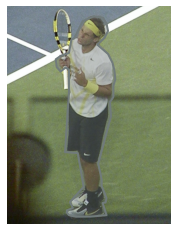

In [34]:
# картинка с  аннотациями для отфильтрованного класса (в данном случае - 'person')
import matplotlib.pyplot as plt
catIds = COCO_dataset_val.cat_ids
imgIds = COCO_dataset_val.img_list
img = COCO_dataset_val.coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('{}/{}/{}'.format('/content/data','val2017',img['file_name']))/255.0
plt.axis('off')
plt.imshow(I)
annIds = COCO_dataset_val.coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = COCO_dataset_val.coco.loadAnns(annIds)
COCO_dataset_val.coco.showAnns(anns)

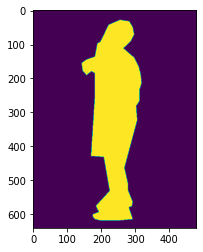

In [35]:
# Бинарная семантическая сегментационная маска
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    mask = np.maximum(COCO_dataset_val.coco.annToMask(anns[i]), mask)
plt.imshow(mask)

In [ ]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')
        self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv9 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv11 = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation= None)

        self.conv12 = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation=None)
        self.pool = tf.keras.layers.MaxPool2D((2, 2))
        self.trasp1 = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')
        self.trasp2 = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')
        self.trasp3 = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')
        self.trasp4 = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')

        
    def call(self, x):
        out = self.conv1(x)
        out = self.pool(out)
        out = self.conv2(out)
        out1 = self.conv3(out)
        out = self.pool(out1)
        out = self.conv4(out)
        out = self.pool(out)
        out = self.conv5(out)
        out = self.pool(out)
        out = self.conv6(out)
        out= self.trasp1(out)
        out = self.conv7(out)
        out = self.trasp2(out)
        out = self.conv8(out)
        out = self.trasp3(out)
        out = tf.concat([out1, out], axis=3)
        out = self.conv9(out)
        out = self.trasp4(out)
        out = self.conv10(out)
        out = self.conv11(out)
        out = tf.image.resize(out, (x.shape[1], x.shape[2]), tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out
    
model = Model()

In [28]:
NUM_EPOCHS = 3
BATCH_SIZE = 64
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])


hist = model.fit(train_ds, epochs=NUM_EPOCHS)

Epoch 1/3
2003/2003 [==============================] - 3401s 2s/step - loss: 0.2760 - acc: 0.8778
Epoch 2/3
2003/2003 [==============================] - 3413s 2s/step - loss: 0.2561 - acc: 0.8884
Epoch 3/3
2003/2003 [==============================] - 3409s 2s/step - loss: 0.2427 - acc: 0.8951


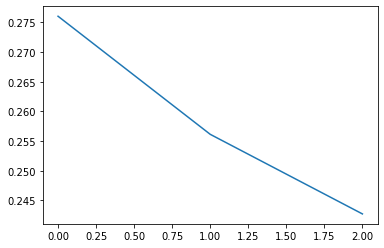

In [39]:
plt.plot(hist.history['loss'])

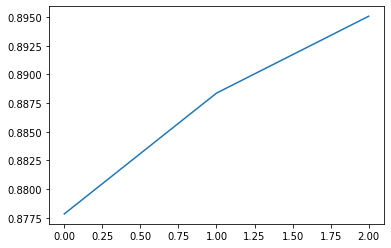

In [40]:
plt.plot(hist.history['acc'])

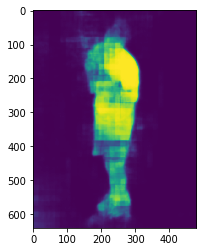

In [36]:
out = model.predict(I[None, ...])[0, ...]
_=plt.imshow(out[...,0])